# Data Exploration:
- Univariate stats: Analysis of individual data
- Bivariate stats: analysis of interactions of 2 variables
- Multivaraiate stats: analysis of interactions of 3+ variables

In [1]:
# personal imports
import wrangle as wr
import pandas as pd
import numpy as np

# visualizations: 
import matplotlib.pyplot as plt
import seaborn as sns

#warnings: 
import warnings
warnings.filterwarnings("ignore")

# math
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

In [2]:
# aquire the data: 
df = wr.get_zillow_data()
df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt,propertylandusetypeid,propertylandusedesc,yearbuilt
0,1,2017-01-01,0.0,0.0,NaN,6037.0,27516.0,261.0,Single Family Residential,NaN
1,15,2017-01-02,0.0,0.0,NaN,6037.0,10.0,261.0,Single Family Residential,NaN
2,16,2017-01-02,0.0,0.0,NaN,6037.0,10.0,261.0,Single Family Residential,NaN
3,17,2017-01-02,0.0,0.0,NaN,6037.0,2108.0,261.0,Single Family Residential,NaN
4,20,2017-01-02,2.0,4.0,3633.0,6037.0,296425.0,261.0,Single Family Residential,2005.0


In [3]:
# clean teh data: 
df = wr.clean_zillow(df)
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt
4,2.0,4.0,3633.0,296425.0,2005.0
6,4.0,3.0,1620.0,847770.0,2011.0
7,2.0,3.0,2077.0,646760.0,1926.0
11,0.0,0.0,1200.0,5328.0,1972.0
14,0.0,0.0,171.0,6920.0,1973.0


In [4]:
# create columns: 
df = wr.create_columns(df)
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
4,2.0,4.0,3633.0,296425.0,2005.0,12.0,6.0
6,4.0,3.0,1620.0,847770.0,2011.0,6.0,7.0
7,2.0,3.0,2077.0,646760.0,1926.0,91.0,5.0
11,0.0,0.0,1200.0,5328.0,1972.0,45.0,0.0
14,0.0,0.0,171.0,6920.0,1973.0,44.0,0.0


# Univarite Stats:
- lets look at the raw data
- No spliting, and no scaling

Distribution of bedrooms


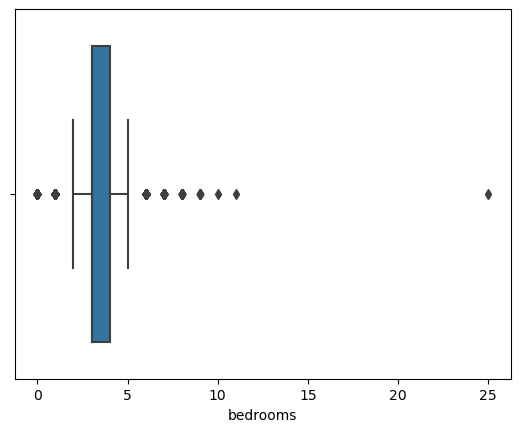

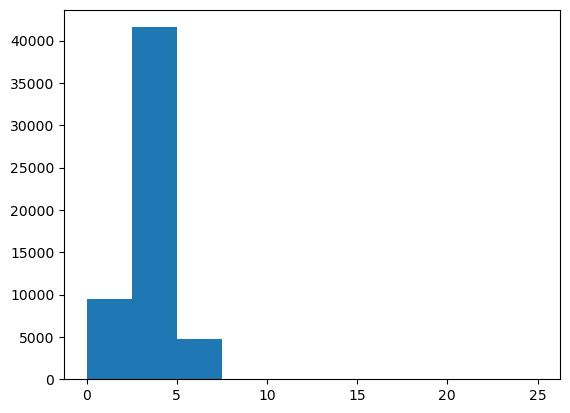

Distribution of bathrooms


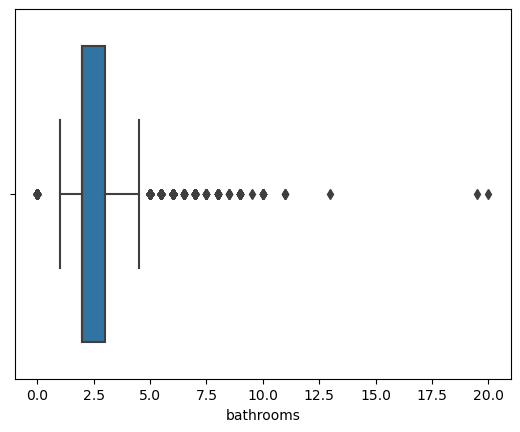

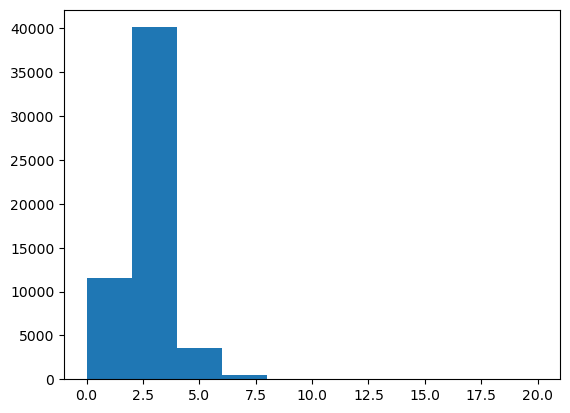

Distribution of sqft


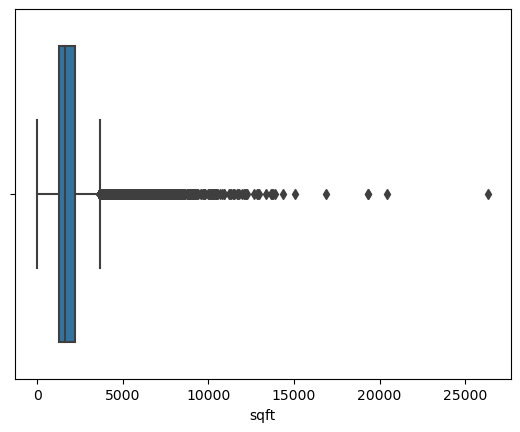

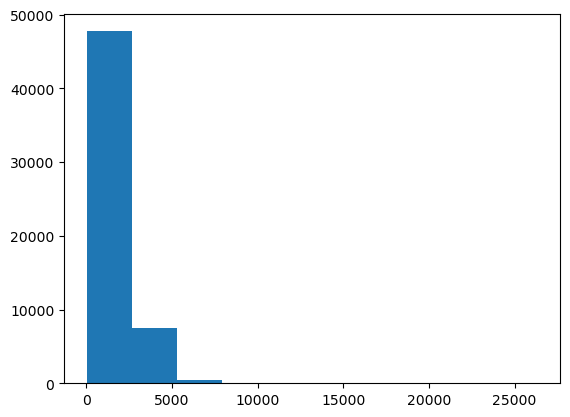

Distribution of yearbuilt


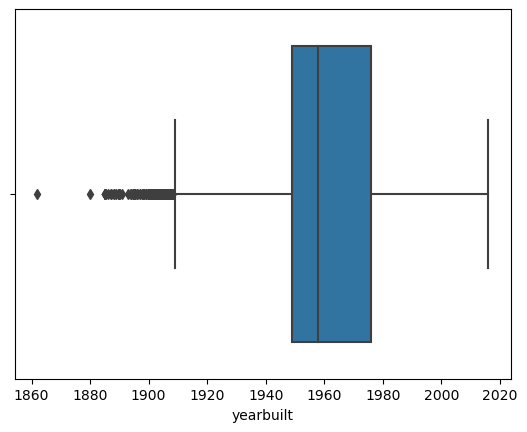

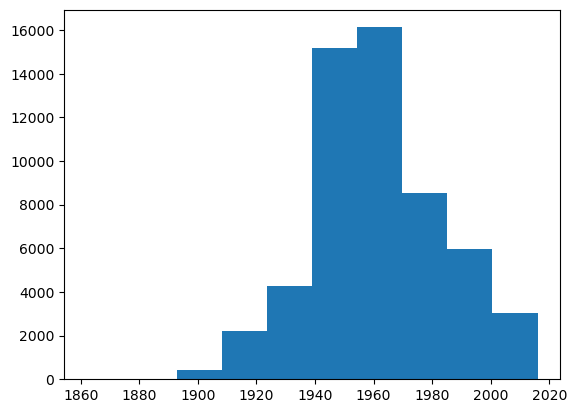

Distribution of house_age


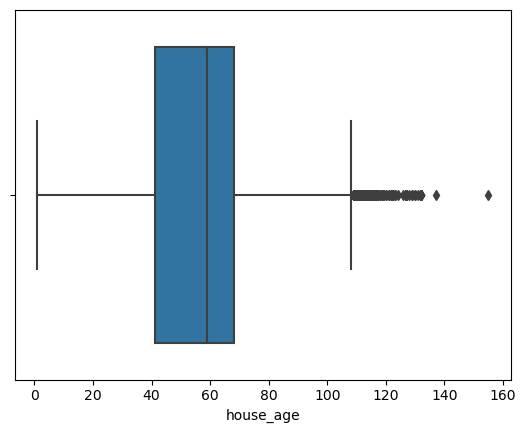

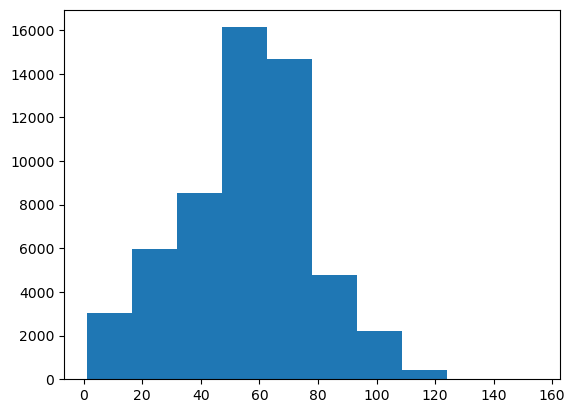

Distribution of bb_roomcnt


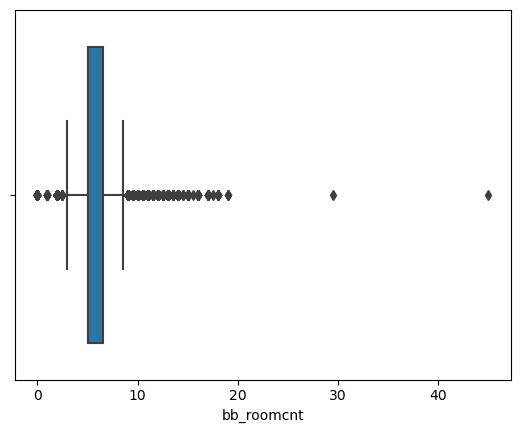

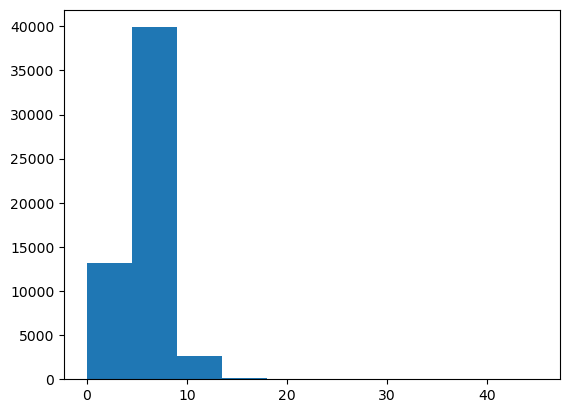

In [5]:
# graph the data:
target = 'tax_value'
columns = ['bedrooms','bathrooms','sqft','yearbuilt','house_age','bb_roomcnt']

for col in columns:
# print out a report header with the column name
    print(f'Distribution of {col}')
    # present a box plot of the information
    # (gives good info about where outliers sit)
    sns.boxplot(data=df, x=col)
    plt.show()
    # present a histogram
    # histogram will establish how Normal our distribution is
    plt.hist(df[col])
    plt.show()
    print('===================')

Whelp as we look at the data we can see there are major outliers in all our columns. Before moving foward we should get rid of the outliers.

In [6]:
def outlier(df, feature, m):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    
    iqr = q3 - q1
    
    multiplier = m
    upper_bound = q3 + (multiplier * iqr)
    lower_bound = q1 - (multiplier * iqr)
    
    return upper_bound, lower_bound

In [7]:
upper_bound, lower_bound = outlier(df, "bedrooms", 3)
upper_bound, lower_bound

(7.0, 0.0)

In [8]:
# lets see how many columns we have before
df.shape

(55812, 7)

In [9]:
# want to remove the outlies
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:
        
        # For each column, it calculates the first quartile (q1) and 
        #third quartile (q3) using the .quantile() method, where q1 
        #corresponds to the 25th percentile and q3 corresponds to the 75th percentile.
        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

Function explanation: <br>

1. First Quartile (Q1):
- Q1 is the median (middle value) of the lower half of the dataset. It separates the lowest 25% of the data from the rest. In mathematical terms, Q1 is the value below which 25% of the data falls.

2. Third Quartile (Q3): Q3 is the median of the upper half of the dataset. It separates the lowest 75% of the data from the highest 25%. In mathematical terms, Q3 is the value below which 75% of the data falls.

3. The interquartile range (IQR) is then calculated as the difference between Q3 and Q1:
- IQR=Q3−Q1

The IQR is used in the context of remove_outliers function to determine the range within which most of the data points lie. Values outside this range are considered potential outliers and are removed based on the specified threshold (k times the IQR) above and below the quartiles.

In [10]:
# lets enact the outliers: 
# With k=3, the range considered for non-outliers is wider, meaning that values farther from the quartiles are 
# retained in the dataset. This makes the method less sensitive to outliers, 
# and more values would be considered within the acceptable range.
all_columns = ['bathrooms','bedrooms','sqft','tax_value','yearbuilt','house_age','bb_roomcnt']
df = remove_outliers(df, 3, all_columns)
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
4,2.0,4.0,3633.0,296425.0,2005.0,12.0,6.0
6,4.0,3.0,1620.0,847770.0,2011.0,6.0,7.0
7,2.0,3.0,2077.0,646760.0,1926.0,91.0,5.0
18,1.0,3.0,1244.0,169471.0,1950.0,67.0,4.0
19,2.0,3.0,1300.0,233266.0,1950.0,67.0,5.0


In [11]:
# how many columns now: 
df.shape

(53493, 7)

In [12]:
# how much dat is lost 
((55812 - 53493)/55812) * 100 

4.155020425714899

In [43]:
df.describe()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
count,53493.000000,53493.000000,53493.000000,5.349300e+04,53493.000000,53493.000000,53493.000000
mean,2.154104,3.258314,1762.716748,3.782558e+05,1960.598733,56.401267,5.412418
std,0.817310,0.863817,709.520153,2.710507e+05,21.449073,21.449073,1.506815
min,0.000000,1.000000,260.000000,7.584000e+03,1880.000000,1.000000,1.000000
25%,2.000000,3.000000,1248.000000,1.828350e+05,1949.000000,43.000000,4.500000
50%,2.000000,3.000000,1600.000000,3.183100e+05,1958.000000,59.000000,5.000000
75%,3.000000,4.000000,2131.000000,5.020280e+05,1974.000000,68.000000,6.000000
max,5.500000,6.000000,4984.000000,1.522235e+06,2016.000000,137.000000,10.000000


In [44]:
df.tax_value.max()

1522235.0

Distribution of bedrooms


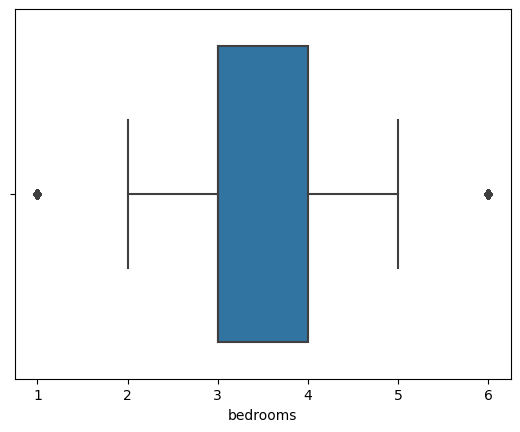

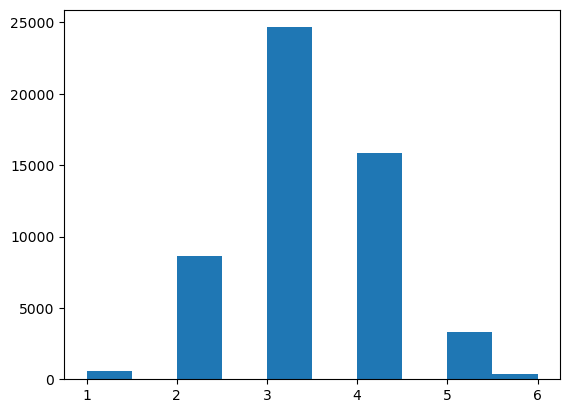

Distribution of bathrooms


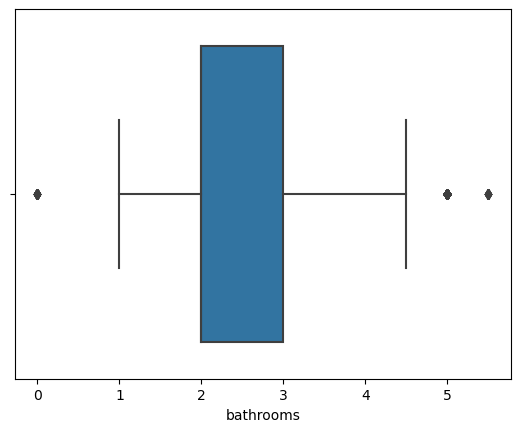

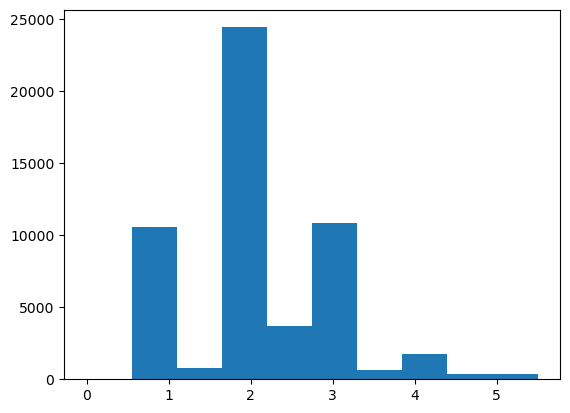

Distribution of sqft


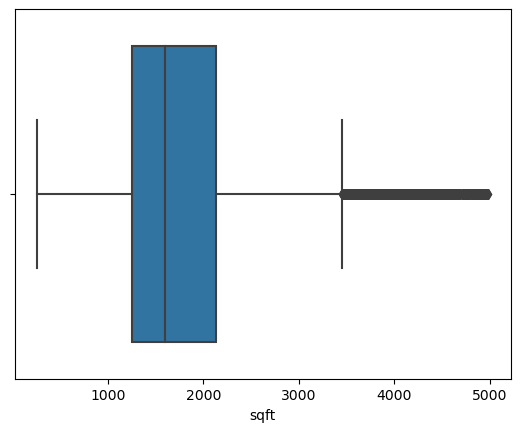

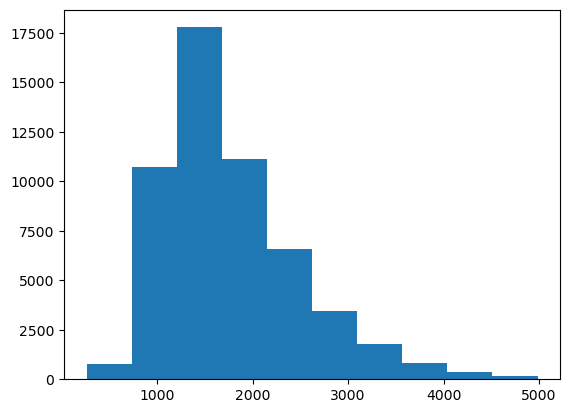

Distribution of yearbuilt


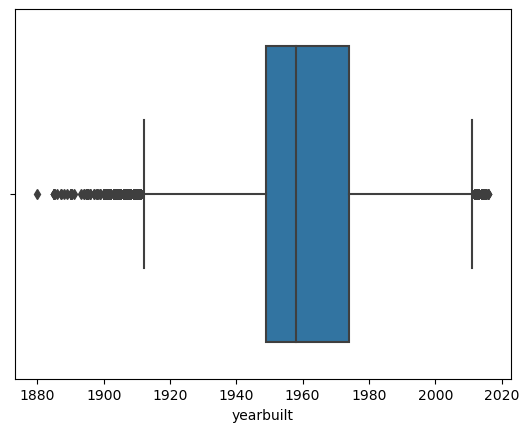

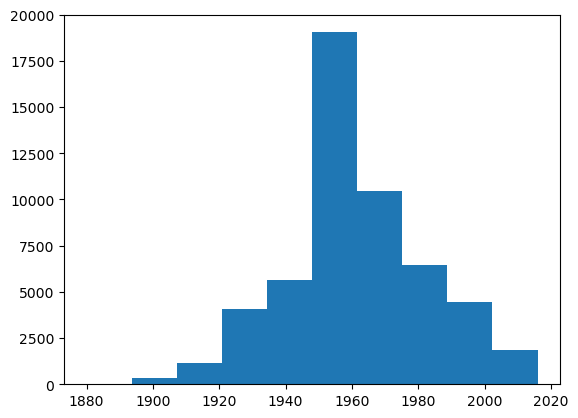

Distribution of house_age


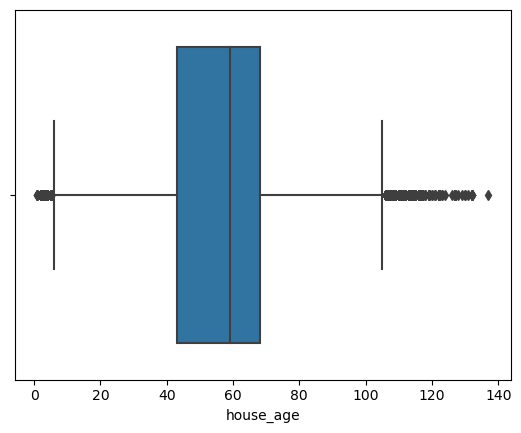

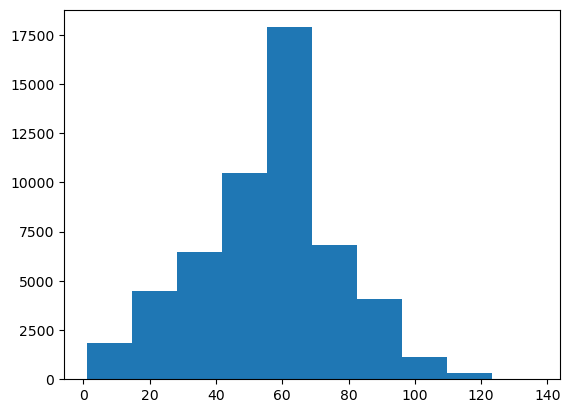

Distribution of bb_roomcnt


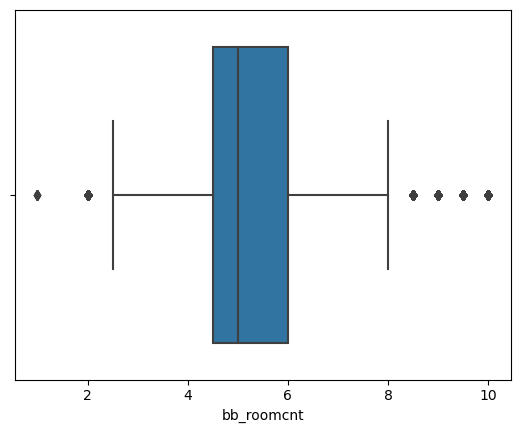

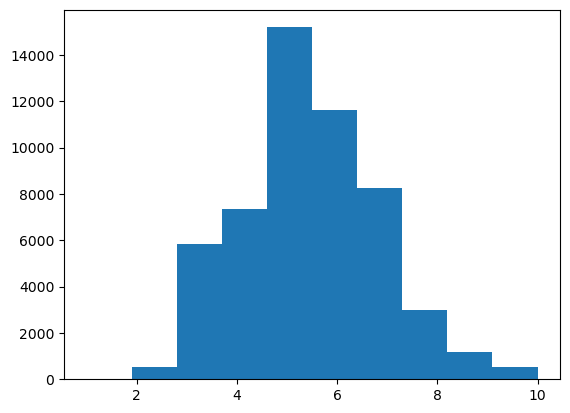

In [13]:
# lets graph this data and see if it looks better: 
for col in columns:
# print out a report header with the column name
    print(f'Distribution of {col}')
    # present a box plot of the information
    # (gives good info about where outliers sit)
    sns.boxplot(data=df, x=col)
    plt.show()
    # present a histogram
    # histogram will establish how Normal our distribution is
    plt.hist(df[col])
    plt.show()
    print('===================')

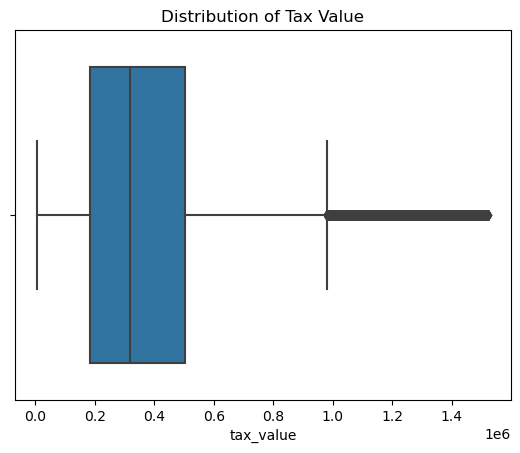

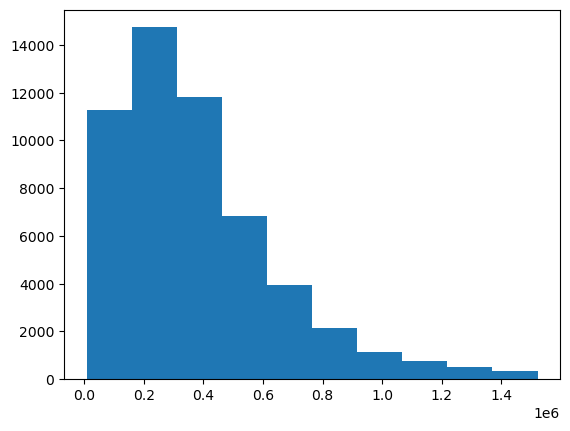

In [14]:
# target variable: 
plt.title('Distribution of Tax Value')
sns.boxplot(data=df, x='tax_value')
plt.show()
plt.hist(df['tax_value'])
plt.show()

## Takeaways: 

1. There are a lot of outliers in the data. I removed 4% of the data by removing the outliers.
2. Bedroom looks normally distributed. The majority of the data sits around 3, the min is 1 and the max is 6. 
2. Bathroom looks normally distributed. The majority of the data sits around 2, the min around .5, and the max around 6.
3. SQFT has positive skew. The averge amount of data is between 1500 and 2000
4. Year built looks partially negative skew.
5. House age looks normal. There are some houses that are 120 years old. 
6. bb count: average number of rooms is 5
7. Tax value has a postive skew. 

# Bi/Multivarite Exploration:
Compare the target to the features. <br>
Initial questions: 
- Does sqft influence taxvalue the most?
- Does the age of the house impact taxvalue?
- Does the number of rooms impact the taxvalue?

### Scale the data

In [15]:
# need to split the data:
train, validate, test = wr.split_zillow_data(df)
train.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
42282,2.5,4.0,1638.0,523394.0,1996.0,21.0,6.5
4905,1.0,3.0,1092.0,34323.0,1951.0,66.0,4.0
48029,2.0,3.0,1178.0,211910.0,1939.0,78.0,5.0
22673,2.0,2.0,1480.0,105574.0,1955.0,62.0,4.0
52519,3.0,3.0,1812.0,604601.0,1951.0,66.0,6.0


In [16]:
#we need to scale all the data to make sure that each freature is on the same level:
import explore as ex
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

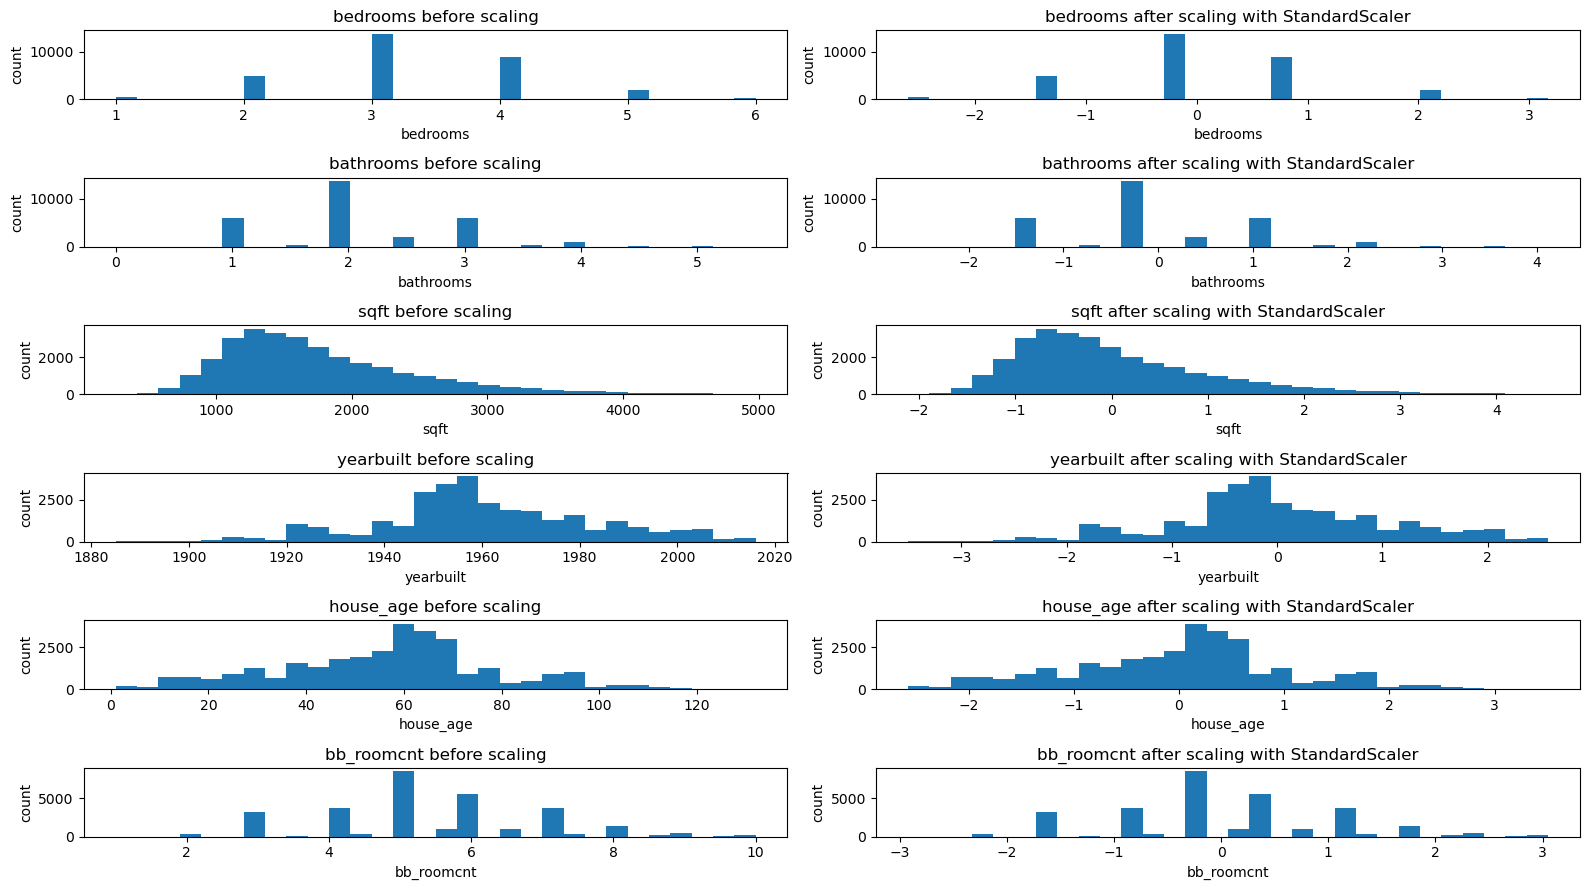

In [17]:
ex.visualize_scaler(scaler=StandardScaler(),
                   df = train,
                   columns_to_scale = columns,
                   bins = 30)

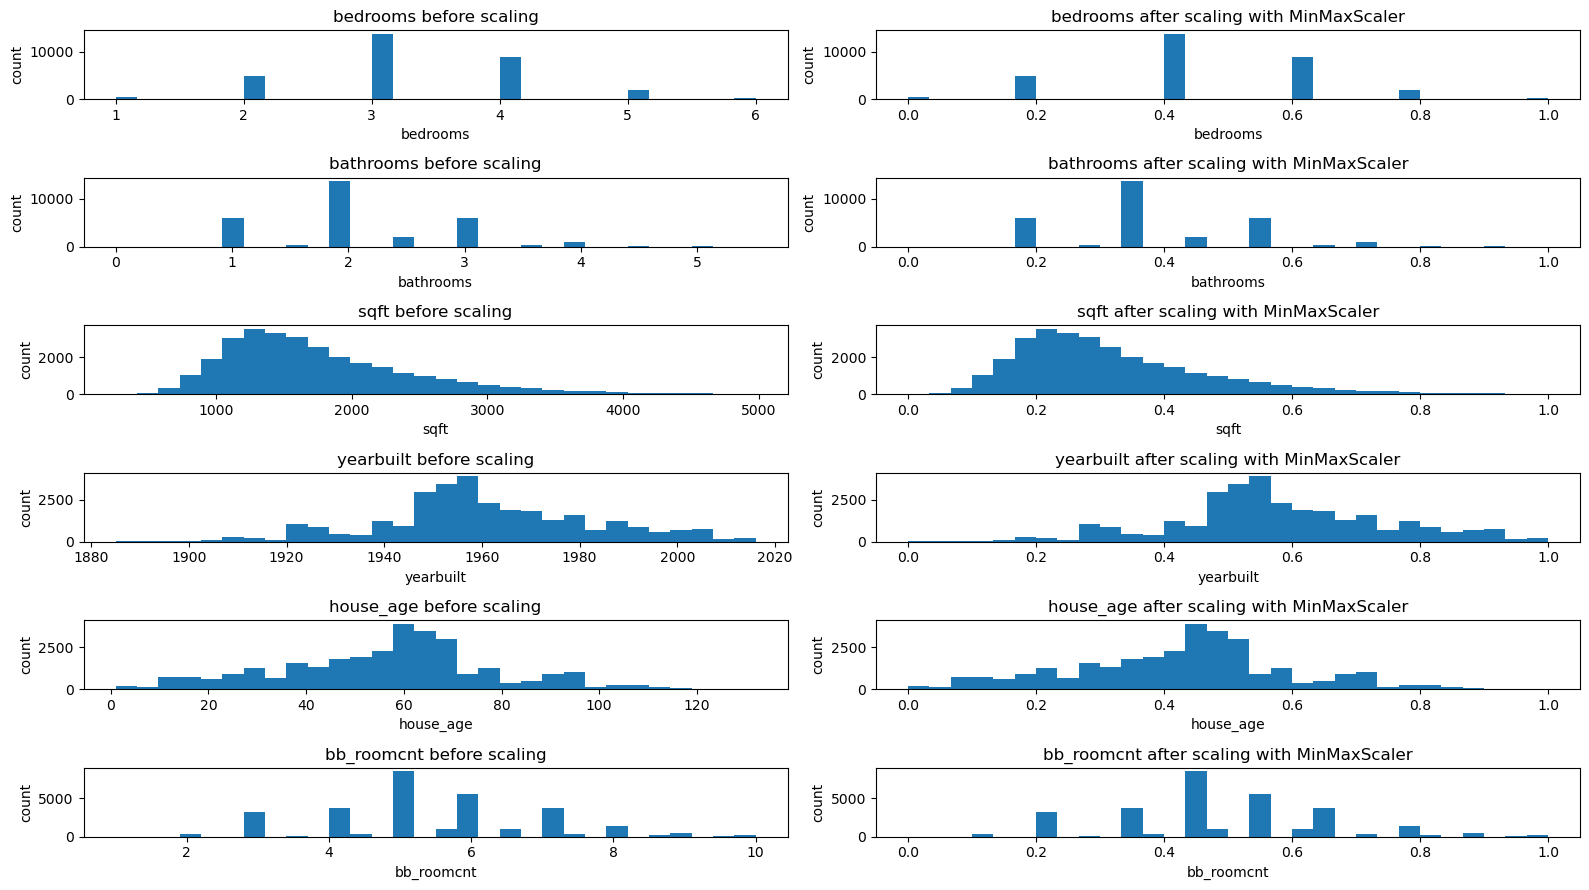

In [18]:
ex.visualize_scaler(scaler=MinMaxScaler(),
                   df = train, 
                   columns_to_scale = columns,
                   bins = 30
                )

In [19]:
# im going to use the MinMaxScaler: 
to_scale = ['bedrooms','bathrooms','sqft','yearbuilt','house_age','bb_roomcnt']

#create the object
scaler = sklearn.preprocessing.MinMaxScaler()

#fit the object: 
scaler.fit(train[to_scale])

# use the object
scaled_train = scaler.transform(train[to_scale])
scaled_train[:10]

array([[0.6       , 0.45454545, 0.29219678, 0.84732824, 0.15267176,
        0.61111111],
       [0.4       , 0.18181818, 0.1764207 , 0.50381679, 0.49618321,
        0.33333333],
       [0.4       , 0.36363636, 0.19465649, 0.41221374, 0.58778626,
        0.44444444],
       [0.2       , 0.36363636, 0.25869381, 0.53435115, 0.46564885,
        0.33333333],
       [0.4       , 0.54545455, 0.32909245, 0.50381679, 0.49618321,
        0.55555556],
       [0.2       , 0.18181818, 0.17366412, 0.29007634, 0.70992366,
        0.22222222],
       [0.2       , 0.18181818, 0.11238338, 0.32824427, 0.67175573,
        0.22222222],
       [0.6       , 0.36363636, 0.23812553, 0.52671756, 0.47328244,
        0.55555556],
       [0.4       , 0.36363636, 0.28753181, 0.52671756, 0.47328244,
        0.44444444],
       [0.4       , 0.36363636, 0.26929601, 0.42748092, 0.57251908,
        0.44444444]])

In [20]:
# adding the columns to the database: 
train[['bedrooms_scaled','bathrooms_scaled','sqft_scaled','yearbuilt_scaled',
       'house_age_scaled','bb_roomcnt_scaled']] = scaled_train
train.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt,bedrooms_scaled,bathrooms_scaled,sqft_scaled,yearbuilt_scaled,house_age_scaled,bb_roomcnt_scaled
42282,2.5,4.0,1638.0,523394.0,1996.0,21.0,6.5,0.6,0.454545,0.292197,0.847328,0.152672,0.611111
4905,1.0,3.0,1092.0,34323.0,1951.0,66.0,4.0,0.4,0.181818,0.176421,0.503817,0.496183,0.333333
48029,2.0,3.0,1178.0,211910.0,1939.0,78.0,5.0,0.4,0.363636,0.194656,0.412214,0.587786,0.444444
22673,2.0,2.0,1480.0,105574.0,1955.0,62.0,4.0,0.2,0.363636,0.258694,0.534351,0.465649,0.333333
52519,3.0,3.0,1812.0,604601.0,1951.0,66.0,6.0,0.4,0.545455,0.329092,0.503817,0.496183,0.555556


In [21]:
scaled_train = train[['bedrooms_scaled','bathrooms_scaled','sqft_scaled','yearbuilt_scaled',
       'house_age_scaled','bb_roomcnt_scaled','tax_value']]
scaled_train.head()

,bedrooms_scaled,bathrooms_scaled,sqft_scaled,yearbuilt_scaled,house_age_scaled,bb_roomcnt_scaled,tax_value
42282,0.6,0.454545,0.292197,0.847328,0.152672,0.611111,523394.0
4905,0.4,0.181818,0.176421,0.503817,0.496183,0.333333,34323.0
48029,0.4,0.363636,0.194656,0.412214,0.587786,0.444444,211910.0
22673,0.2,0.363636,0.258694,0.534351,0.465649,0.333333,105574.0
52519,0.4,0.545455,0.329092,0.503817,0.496183,0.555556,604601.0


In [22]:
# make a clean df:
train, validate, test = wr.prep_zillow()

In [23]:
# make a function to do it the easy way: 
def scale_data(train, 
               validate, 
               test, 
               to_scale):
    #make copies for scaling
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()

    #scale them!
    #make the thing
    scaler = MinMaxScaler()

    #fit the thing
    scaler.fit(train[to_scale])

    #use the thing
    train_scaled[to_scale] = scaler.transform(train[to_scale])
    validate_scaled[to_scale] = scaler.transform(validate[to_scale])
    test_scaled[to_scale] = scaler.transform(test[to_scale])
    
    return train_scaled, validate_scaled, test_scaled

In [24]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, to_scale)

In [25]:
train_scaled.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
42282,0.454545,0.6,0.292197,523394.0,0.847328,0.152672,0.611111
4905,0.181818,0.4,0.176421,34323.0,0.503817,0.496183,0.333333
48029,0.363636,0.4,0.194656,211910.0,0.412214,0.587786,0.444444
22673,0.363636,0.2,0.258694,105574.0,0.534351,0.465649,0.333333
52519,0.545455,0.4,0.329092,604601.0,0.503817,0.496183,0.555556


## Explore: 
1. Graphs
2. Quetions

In [26]:
# tax value is normall or not: 
# function to evaluate if distribution is normal
def eval_dist(r, p, α=0.05):
    """
    This function will take in:
    - r: the test statistic
    - p: p-value
    - α: id defaulted to 5%
    and print out if the data used to create r & p from the stats.shapiro test is normally distributed.
    """
    if p > α:
        return print(f"""The data is normally distributed""")
    else:
        return print(f"""The data is NOT normally distributed""")

r, p = stats.shapiro(train_scaled.tax_value)
r, p
eval_dist(r, p)

The data is NOT normally distributed


#### Heatmap: 

In [27]:
train_corr = train_scaled.corr(method='spearman')
train_corr

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
bathrooms,1.000000,0.610180,0.809616,0.434029,0.583586,-0.583586,0.882024
bedrooms,0.610180,1.000000,0.637436,0.261578,0.435211,-0.435211,0.900791
sqft,0.809616,0.637436,1.000000,0.480308,0.522667,-0.522667,0.799252
tax_value,0.434029,0.261578,0.480308,1.000000,0.282196,-0.282196,0.380283
yearbuilt,0.583586,0.435211,0.522667,0.282196,1.000000,-1.000000,0.557629
house_age,-0.583586,-0.435211,-0.522667,-0.282196,-1.000000,1.000000,-0.557629
bb_roomcnt,0.882024,0.900791,0.799252,0.380283,0.557629,-0.557629,1.000000


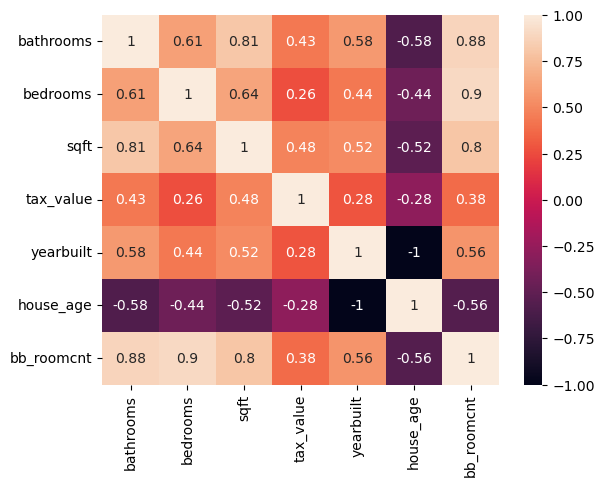

In [28]:
# heatmap 
sns.heatmap(train_corr, annot=True)
plt.show()

In [29]:
# data that is not scaled: 
train_corr_2 = train.corr(method='spearman')
train_corr_2

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
bathrooms,1.000000,0.610180,0.809616,0.434029,0.583586,-0.583586,0.882024
bedrooms,0.610180,1.000000,0.637436,0.261578,0.435211,-0.435211,0.900791
sqft,0.809616,0.637436,1.000000,0.480308,0.522667,-0.522667,0.799252
tax_value,0.434029,0.261578,0.480308,1.000000,0.282196,-0.282196,0.380283
yearbuilt,0.583586,0.435211,0.522667,0.282196,1.000000,-1.000000,0.557629
house_age,-0.583586,-0.435211,-0.522667,-0.282196,-1.000000,1.000000,-0.557629
bb_roomcnt,0.882024,0.900791,0.799252,0.380283,0.557629,-0.557629,1.000000


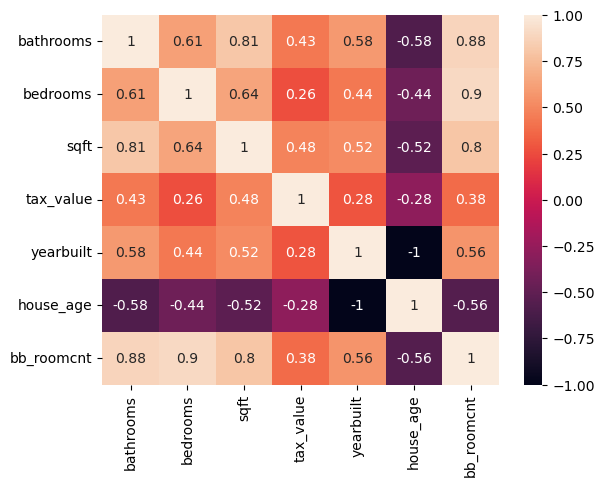

In [30]:
# heatmap 
sns.heatmap(train_corr_2, annot=True)
plt.show()

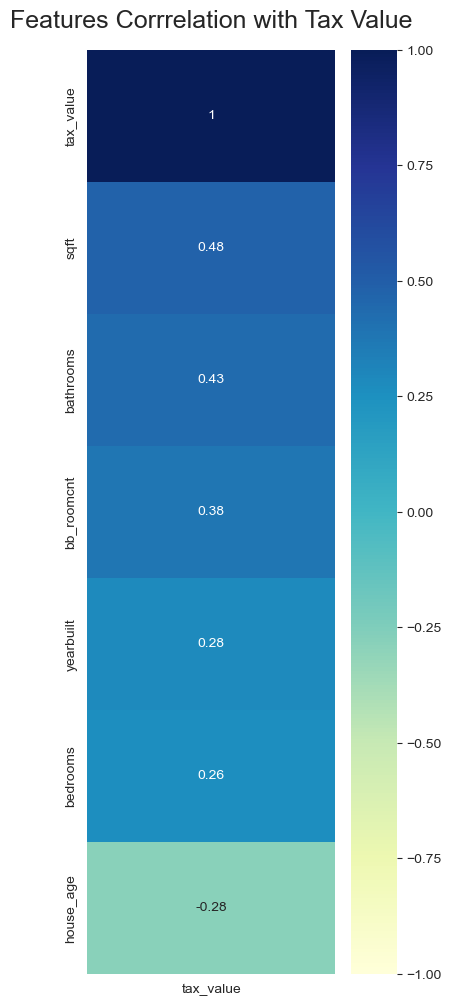

In [31]:
# make a better heatmap
plt.figure(figsize=(4, 12))
sns.set_style("darkgrid")
heatmap = sns.heatmap(train.corr(method='spearman')[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Features Corrrelation with Tax Value', fontdict={'fontsize':18}, pad=16);


The top 3 features with the strongest correlation: 
- Sqft -> increase tax value
- Bathrooms -> increase tax value
- House_age <- deacrease tax value

lmplot for bedrooms


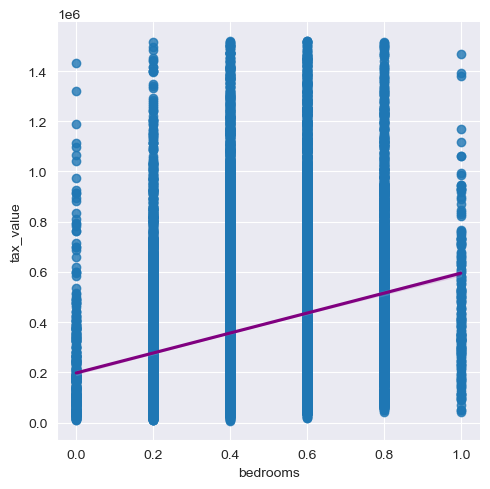

------------------
lmplot for bathrooms


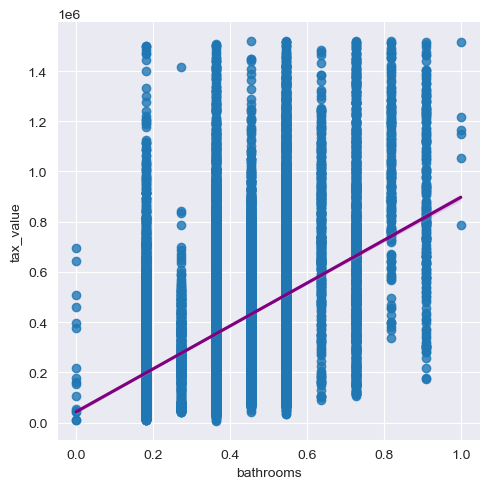

------------------
lmplot for sqft


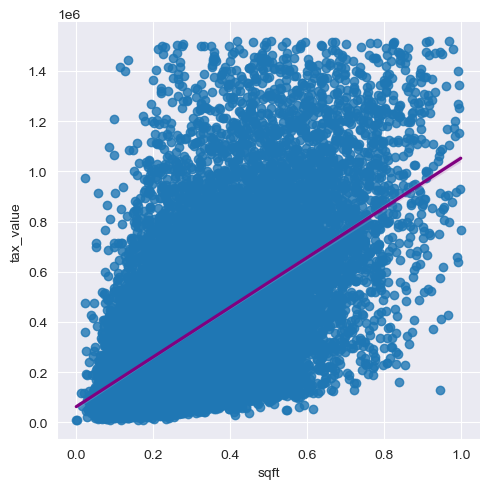

------------------
lmplot for yearbuilt


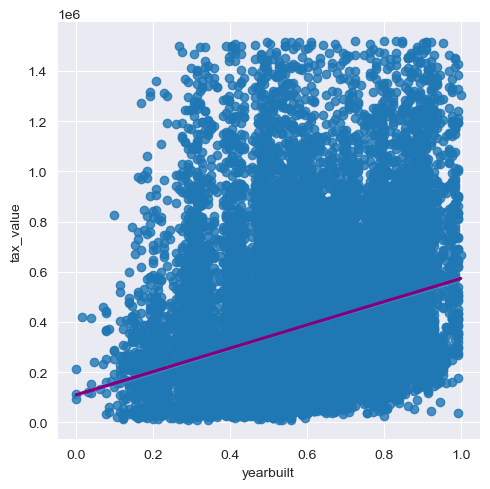

------------------
lmplot for house_age


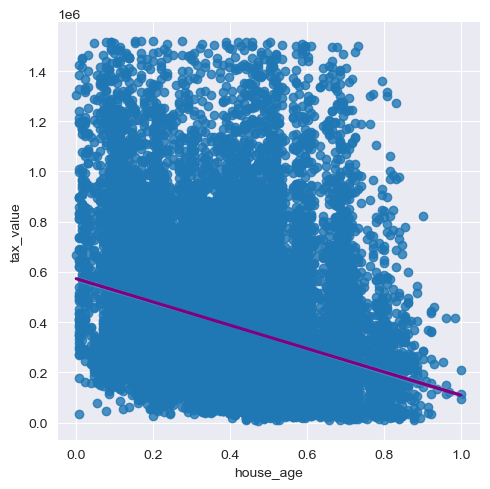

------------------
lmplot for bb_roomcnt


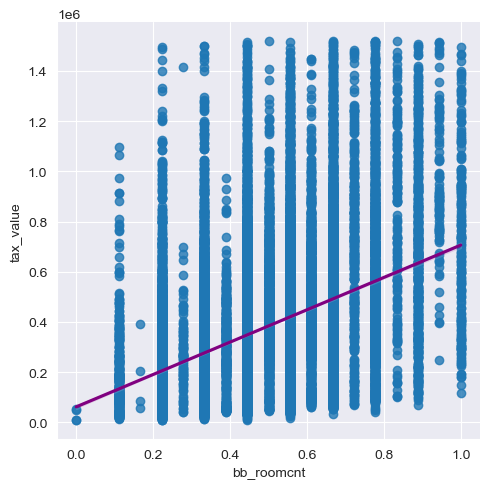

------------------


In [32]:
# relplot: 
target = 'tax_value'
columns = ['bedrooms', 'bathrooms','sqft','yearbuilt','house_age','bb_roomcnt']

for col in columns:
    print(f'lmplot for {col}')
    sns.lmplot(data=train_scaled, x = col , y = target, 
              line_kws={'color':'purple'})
    plt.show()
    print('------------------')      

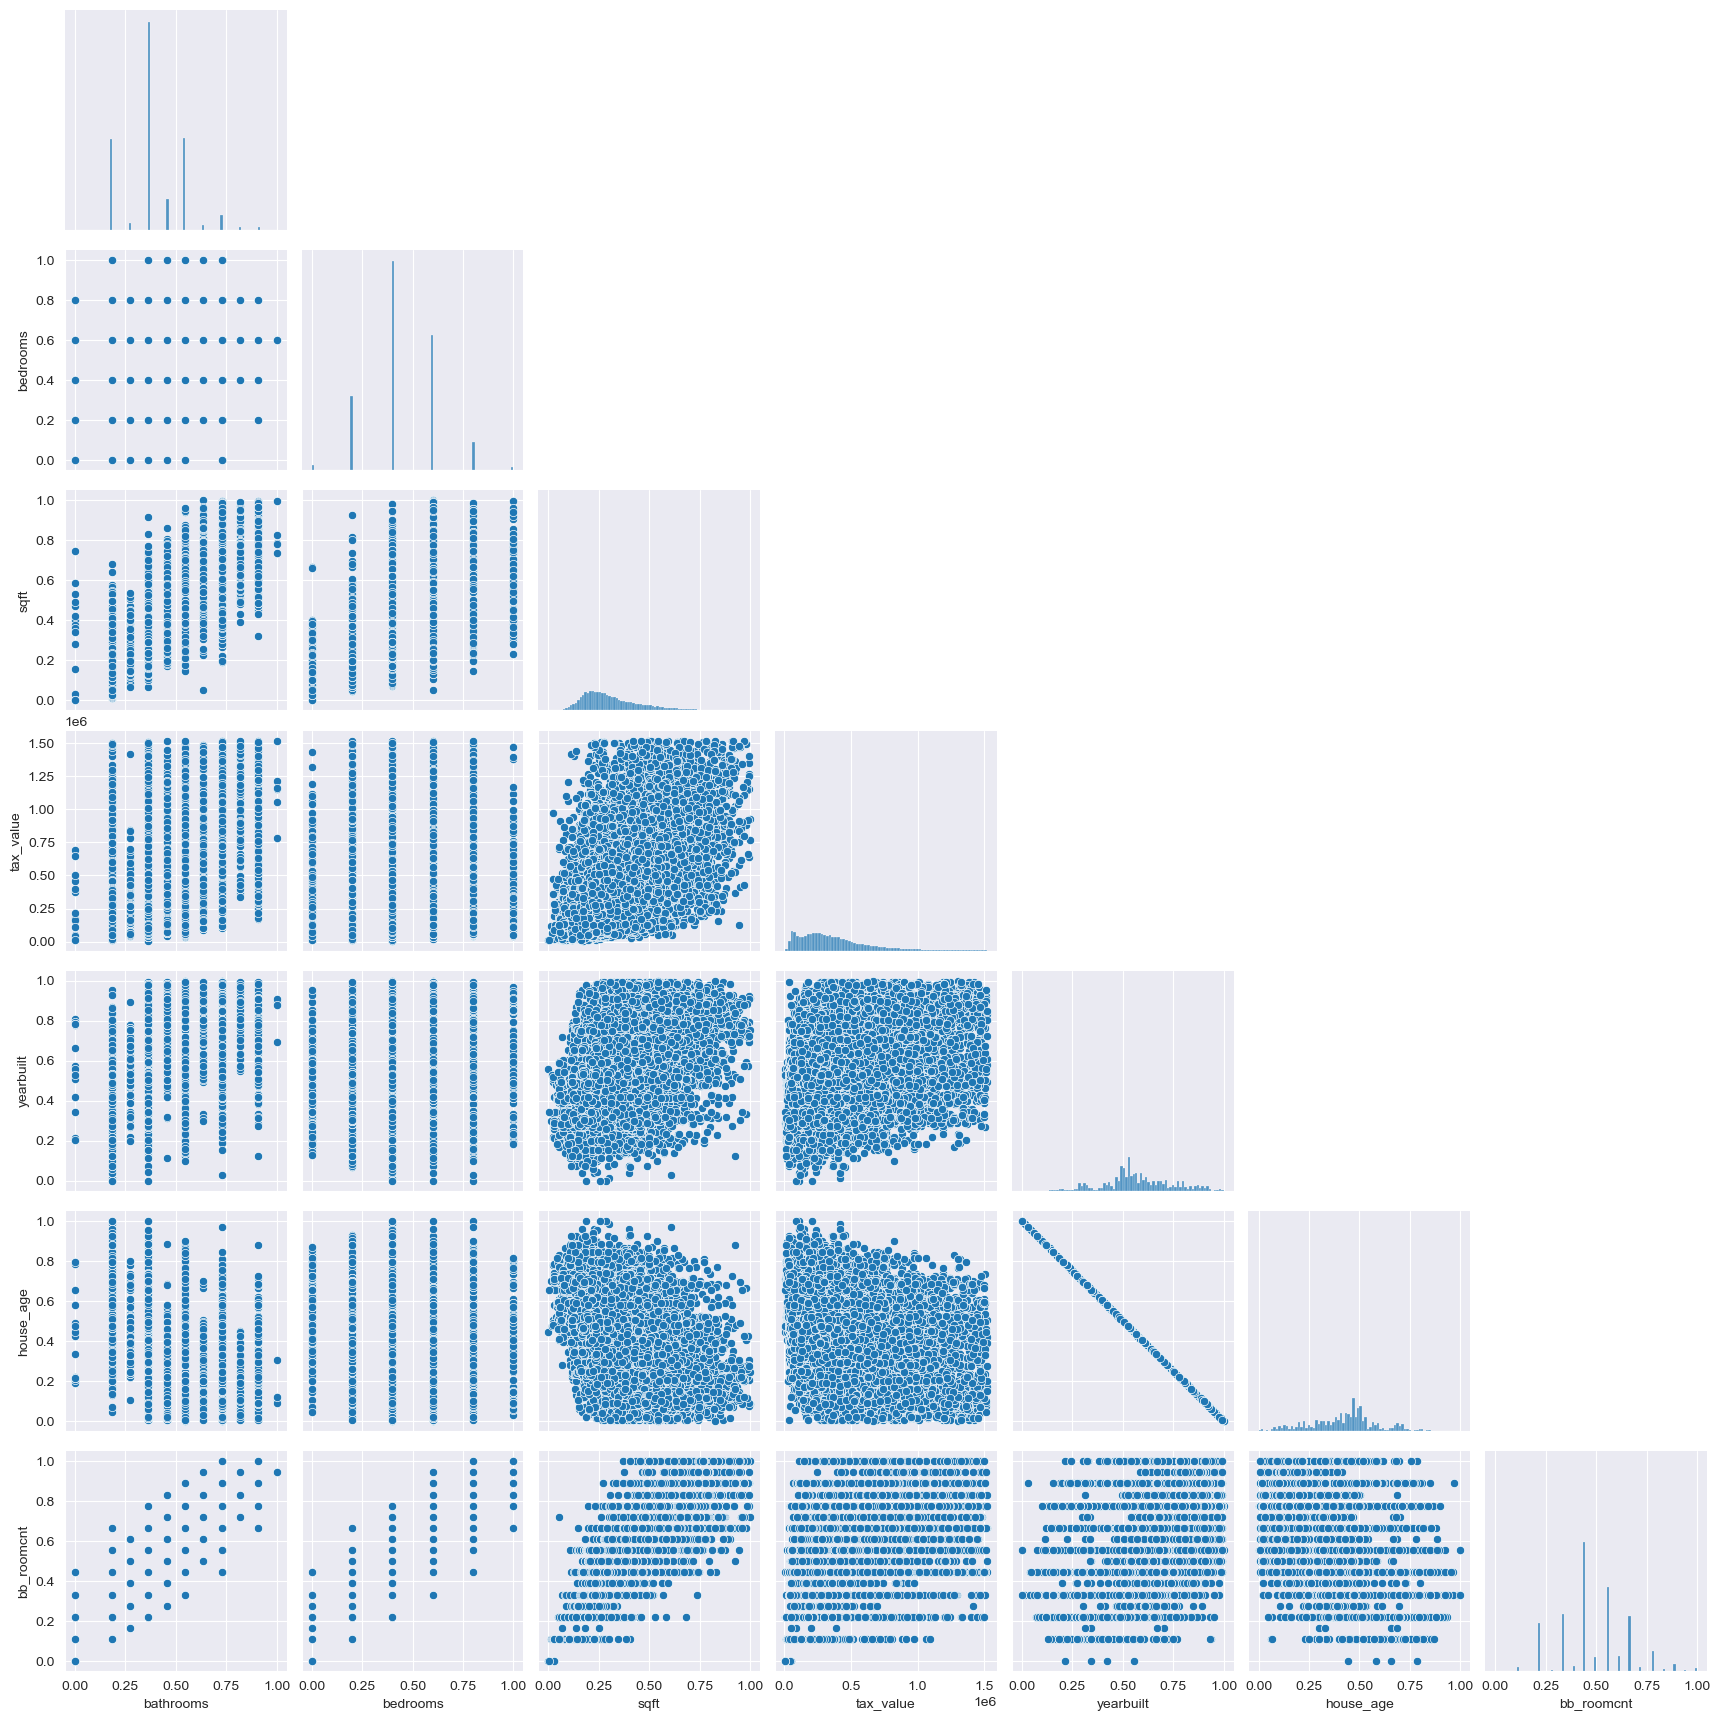

In [33]:
# create a pairplot:
sns.pairplot(train_scaled, corner = True)
plt.show()

<div class="alert alert-success" role="alert">
    Takeaways: 
    <br>
    - There may be a relationship between `sqft` and tax value <br>
    - There may be a relationship between `bathrooms` and tax value <br>
    - There may be a relationship between `house age` and tax value <br>

# Hypothesis testing: 
Q1. Is there a relationship between `sqft` and tax value? <br>
Q2. Is there a relationship between `batrooms` and tax value? <br>
Q3. Is there a realtionship between `house_age` and tax value? <br>
Q4. Is there a relationship between `roomcnt` and tax value? <br>

### 1. Is there a realtionship between sqft and tax value?
- $H_0$: There is no monotonic relationship between sqft and tax value.
- $H_a$: There is a montonic relationship between sqft and tax value.

In [34]:
α=0.05
r, p = spearmanr(train_scaled.tax_value, train_scaled.sqft)
if p < α:
        print(f"""We reject H₀, there is a monotonic relationship.
            Spearman’s r: {r:2f}
            P-value: {p}""")
else:
        print(f"""We fail to reject H₀: that there is a monotonic relationship.
                    Spearman’s r: {r:2f}
                    P-value: {p}""")

We reject H₀, there is a monotonic relationship.
            Spearman’s r: 0.480308
            P-value: 0.0


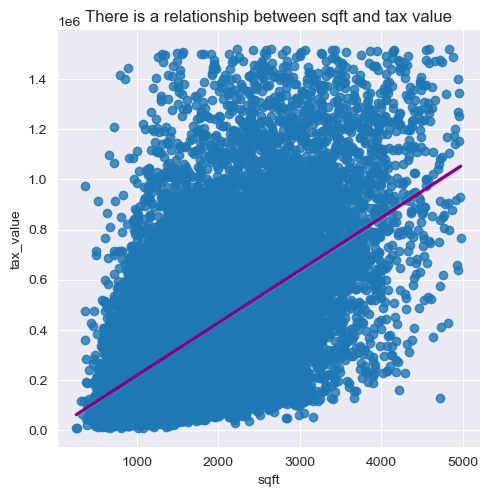

In [35]:
# lets make a graph: 
sns.lmplot(data=train, x ='sqft', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between sqft and tax value")
plt.show()

### 2. Is there a realtionship between bathrooms and tax value?
- $H_0$: There is no monotonic relationship between bathrooms and tax value.
- $H_a$: There is a montonic relationship between bathrooms and tax value.

In [36]:
r, p = spearmanr(train_scaled.tax_value, train_scaled.sqft)
ex.eval_Spearman(r, p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.480308
P-value: 0.0


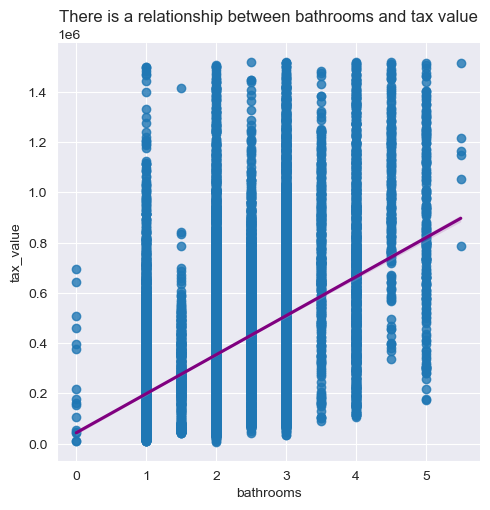

In [37]:
# lets make a graph: 
sns.lmplot(data=train, x ='bathrooms', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between bathrooms and tax value")
plt.show()

### 3. Is there a realtionship between house_age and tax value?
- $H_0$: There is no monotonic relationship between house age and tax value.
- $H_a$: There is a montonic relationship between house age and tax value.

In [38]:
r, p = spearmanr(train_scaled.tax_value, train_scaled.house_age)
ex.eval_Spearman(r, p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: -0.282196
P-value: 0.0


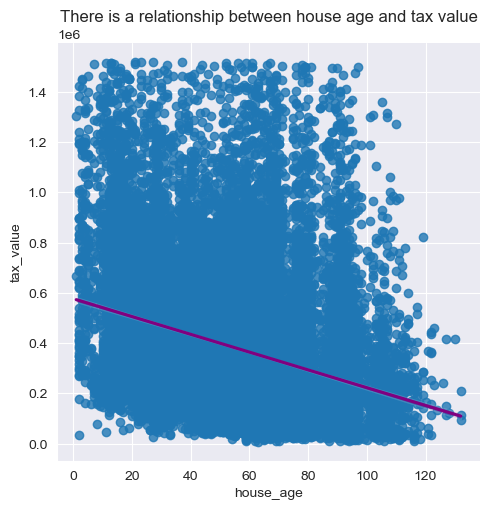

In [39]:
# lets make a graph: 
sns.lmplot(data=train, x ='house_age', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between house age and tax value")
plt.show()

### 4. Is there a realtionship between bb_roomcnt and tax value?
- $H_0$: There is no monotonic relationship between bb_roomcnt and tax value.
- $H_a$: There is a montonic relationship between bb_roomcnt and tax value.

In [40]:
r, p = spearmanr(train.tax_value, train.bb_roomcnt)
ex.eval_Spearman(r, p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.380283
P-value: 0.0


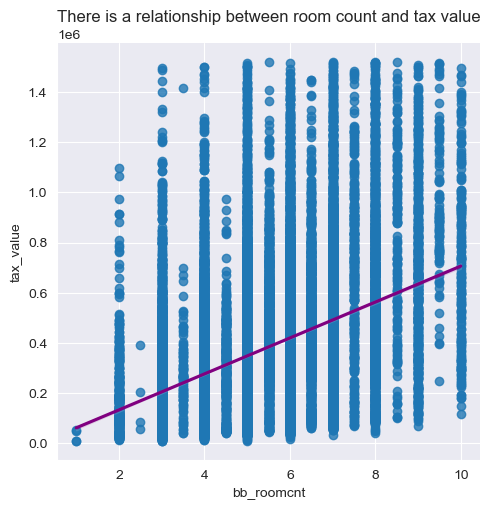

In [41]:
# lets make a graph: 
sns.lmplot(data=train, x ='bb_roomcnt', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between room count and tax value")
plt.show()

# Extra

Compare young, medium, old, houses means to show a difference for tax value

<Axes: xlabel='house_age', ylabel='tax_value'>

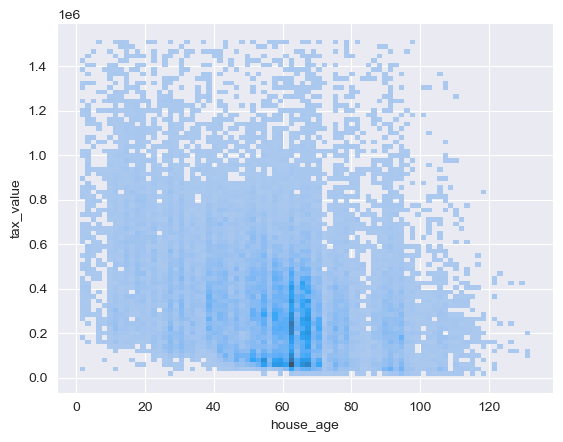

In [42]:
sns.histplot(data = train, x = 'house_age', y = 'tax_value')